In [1]:
from skimage.io import imread
import napari_segment_blobs_and_things_with_membranes as nsbatwm  # version 0.3.3
import napari
import pyclesperanto_prototype as cle  # version 0.21.2
import pandas as pd
from napari_simpleitk_image_processing import label_statistics

import napari_skimage_regionprops as nsr

from sklearn.preprocessing import StandardScaler
import seaborn
import stackview
# import umap
# from numba.np.ufunc import _internal

# if 'viewer' not in globals():
#     viewer = napari.Viewer()


In [2]:
# from skimage.io import imread
# import napari

In [3]:
stack = imread('data/node_crop_small.tif')
stack.shape

(181, 1134, 1134)

In [4]:
# type(stack)

In [5]:
frame_100 = stack[100]
# frame_101 = stack[101]

In [6]:
viewer = napari.Viewer()

In [7]:
viewer.add_image(frame_100)

<Image layer 'frame_100' at 0x18812c9d0>

In [8]:
# image0_f1 = viewer.layers['frame_100'].data

# local minima seeded watershed

frame_100_lmsw = nsbatwm.local_minima_seeded_watershed(frame_100, 25.0, 5.0)

viewer.add_labels(frame_100_lmsw, name='lmsw_25_5')


<Labels layer 'lmsw_25_5' at 0x18805f6a0>

In [9]:
voxel_size_xy = 1
voxel_size_z  = 5
zoom          = 0.25 

cl.OCLArray([[[ 6.,  0.,  2., ...,  4.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  3.,  1.,  0.],
        ...,
        [ 4.,  0.,  1., ...,  0.,  0.,  0.],
        [ 0.,  8.,  4., ..., 18.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 3., 19.,  1., ...,  5.,  1.,  0.],
        [ 0.,  0.,  3., ...,  5.,  0.,  0.],
        [ 1.,  0.,  9., ..., 12.,  1.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  7.,  2.,  0.],
        [ 7.,  0.,  2., ...,  8., 21.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[15.,  7.,  4., ..., 10.,  0.,  0.],
        [ 5.,  4.,  6., ...,  3.,  0.,  0.],
        [ 1.,  3.,  2., ...,  0.,  9.,  0.],
        ...,
        [ 3.,  0.,  1., ...,  4., 34.,  0.],
        [ 0.,  0.,  0., ..., 22.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[ 0.,  0.,  0., ...,  0.,  4.,  0.],
        [ 0.,  0.,  3., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  2.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 6.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  2., ...,  0.,  1.,  0.],
        [ 1.,  0.,  0., ...,  0., 10.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 2.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32)
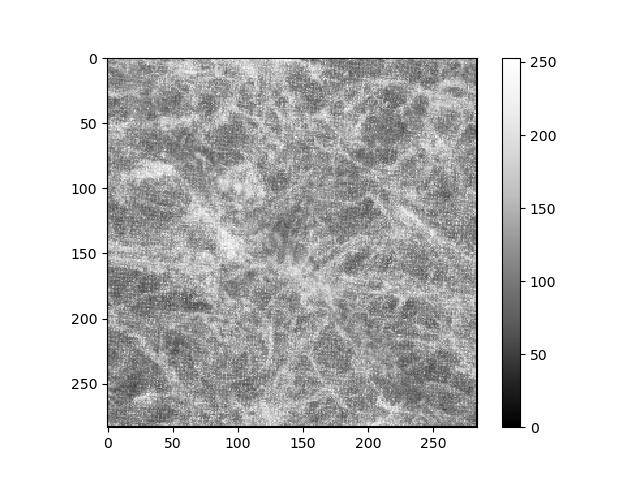
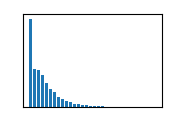

In [10]:
image1_s = cle.scale(stack, factor_x=voxel_size_xy*zoom, factor_y=voxel_size_xy*zoom, factor_z=voxel_size_z*zoom, auto_size=True,) #  linear_interpolation=True linear interpolation not supported on intel cpu
image1_s

In [11]:
viewer_3d = napari.Viewer()
viewer_3d.add_image(image1_s)

<Image layer 'image1_s' at 0x1a1fdcb50>

In [12]:
lmsw_3d = nsbatwm.local_minima_seeded_watershed(image1_s, 25.0*zoom, 5.0*zoom)

In [13]:
# lmsw_labels = viewer_3d.add_labels(lmsw_3d)

In [14]:
# exclude labels on the edge of the stack
image1_eloe = cle.exclude_labels_on_edges(lmsw_3d)
# viewer.add_labels(
#     image1_eloe, name='Result of exclude_labels_on_edges (clesperanto)')

In [15]:
# exclude small labels
image2_esl = cle.exclude_small_labels(image1_eloe, None, 100.0) # base small on zoom in future
# viewer.add_labels(
#     image2_esl, name='Result of exclude_small_labels (clesperanto)')

In [16]:
labels_3d_layer = viewer_3d.add_labels(image2_esl)

In [17]:
cle.available_device_names()

['Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz',
 'Intel(R) UHD Graphics 630',
 'AMD Radeon Pro 560X Compute Engine']

In [18]:
# cle.select_device('GPU')
# from pyopencl.cache import create_built_program_from_source_cached
# print(cle.cl_info())

In [19]:
# cle.statistics_of_labelled_pixels(image1_s, image2_esl)

In [20]:
statistics = label_statistics(image1_s, image2_esl, 
                              intensity=True, 
                              size=True, 
                              shape=True, 
                              perimeter=False, 
                              position=False,
                              moments=False
                             )


In [21]:
label_statistics_df = pd.DataFrame(statistics)
labels_3d_layer.properties = label_statistics_df
nsr.add_table(labels_3d_layer, viewer_3d)
label_statistics_df

Napari status bar display of label properties disabled because https://github.com/napari/napari/issues/5417 and https://github.com/napari/napari/issues/4342


,label,maximum,mean,median,minimum,sigma,sum,variance,elongation,feret_diameter,flatness,roundness,equivalent_ellipsoid_diameter_0,equivalent_ellipsoid_diameter_1,equivalent_ellipsoid_diameter_2,equivalent_spherical_perimeter,equivalent_spherical_radius,number_of_pixels,number_of_pixels_on_border
0,1,230.0,35.512608,26.189453,0.0,32.993851,1916793.0,1088.594197,1.349661,76.544105,1.147122,0.0,38.718333,44.414665,59.944728,6906.837291,23.444160,53975,0
1,2,220.0,27.617796,20.259766,0.0,26.600750,1936118.0,707.599892,2.483532,115.290936,1.256246,0.0,32.447027,40.761463,101.232395,8222.035046,25.579069,70104,0
2,3,219.0,39.940580,31.130859,0.0,31.716282,3196844.0,1005.922555,2.481217,125.638370,1.410939,0.0,31.396103,44.297985,109.912920,8981.637257,26.734547,80040,0
3,4,212.0,41.341011,34.095703,0.0,32.709690,746660.0,1069.923849,1.520062,59.615434,1.329765,0.0,23.412294,31.132859,47.323865,3328.986134,16.276127,18061,0
4,5,220.0,35.079868,29.154297,0.0,29.002720,1219727.0,841.157790,1.733937,76.954532,1.600460,0.0,24.635483,39.428098,68.365839,5151.739781,20.247529,34770,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,94,202.0,27.684596,21.248047,0.0,25.226441,1718106.0,636.373327,1.492187,104.980951,2.184547,0.0,25.532247,55.776400,83.228798,7580.397365,24.560718,62060,0
94,95,195.0,26.091765,21.248047,0.0,23.276382,1545624.0,541.789982,1.088196,87.943163,2.473566,0.0,25.708847,63.592531,69.201110,7348.821795,24.182652,59238,0
95,96,168.0,25.973086,21.248047,0.0,21.558554,1272889.0,464.771267,1.713993,96.140522,2.275457,0.0,21.930101,49.901011,85.529981,6476.327128,22.701756,49008,0
96,97,179.0,23.851543,19.271484,0.0,21.107724,1440347.0,445.536027,1.467387,88.532480,1.886723,0.0,28.054145,52.930394,77.669384,7443.626193,24.338138,60388,0


In [22]:
# nsr.add_table(labels_3d_layer, viewer_3d)

In [23]:
# df.isna().values.any()

In [24]:
list(label_statistics_df.columns)

['label',
 'maximum',
 'mean',
 'median',
 'minimum',
 'sigma',
 'sum',
 'variance',
 'elongation',
 'feret_diameter',
 'flatness',
 'roundness',
 'equivalent_ellipsoid_diameter_0',
 'equivalent_ellipsoid_diameter_1',
 'equivalent_ellipsoid_diameter_2',
 'equivalent_spherical_perimeter',
 'equivalent_spherical_radius',
 'number_of_pixels',
 'number_of_pixels_on_border']

In [25]:
selected_table = label_statistics_df[
    [
        # 'label',
         'maximum',
         'mean',
         'median',
         'minimum',
         'sigma',
         'sum',
         'variance',
         'elongation',
         'feret_diameter',
         'flatness',
         # 'roundness',
         'equivalent_ellipsoid_diameter_0',
         'equivalent_ellipsoid_diameter_1',
         'equivalent_ellipsoid_diameter_2',
         'equivalent_spherical_perimeter',
         'equivalent_spherical_radius',
         'number_of_pixels',
         'number_of_pixels_on_border'
    ]
]

selected_statistics = selected_table.values
selected_statistics

array([[2.30000000e+02, 3.55126077e+01, 2.61894531e+01, ...,
        2.34441602e+01, 5.39750000e+04, 0.00000000e+00],
       [2.20000000e+02, 2.76177964e+01, 2.02597656e+01, ...,
        2.55790688e+01, 7.01040000e+04, 0.00000000e+00],
       [2.19000000e+02, 3.99405797e+01, 3.11308594e+01, ...,
        2.67345466e+01, 8.00400000e+04, 0.00000000e+00],
       ...,
       [1.68000000e+02, 2.59730860e+01, 2.12480469e+01, ...,
        2.27017563e+01, 4.90080000e+04, 0.00000000e+00],
       [1.79000000e+02, 2.38515434e+01, 1.92714844e+01, ...,
        2.43381378e+01, 6.03880000e+04, 0.00000000e+00],
       [1.89000000e+02, 3.03526310e+01, 2.61894531e+01, ...,
        2.20872483e+01, 4.51350000e+04, 0.00000000e+00]])

In [26]:
scaled_statistics = StandardScaler().fit_transform(selected_statistics)

type(scaled_statistics), scaled_statistics.shape

(numpy.ndarray, (98, 17))

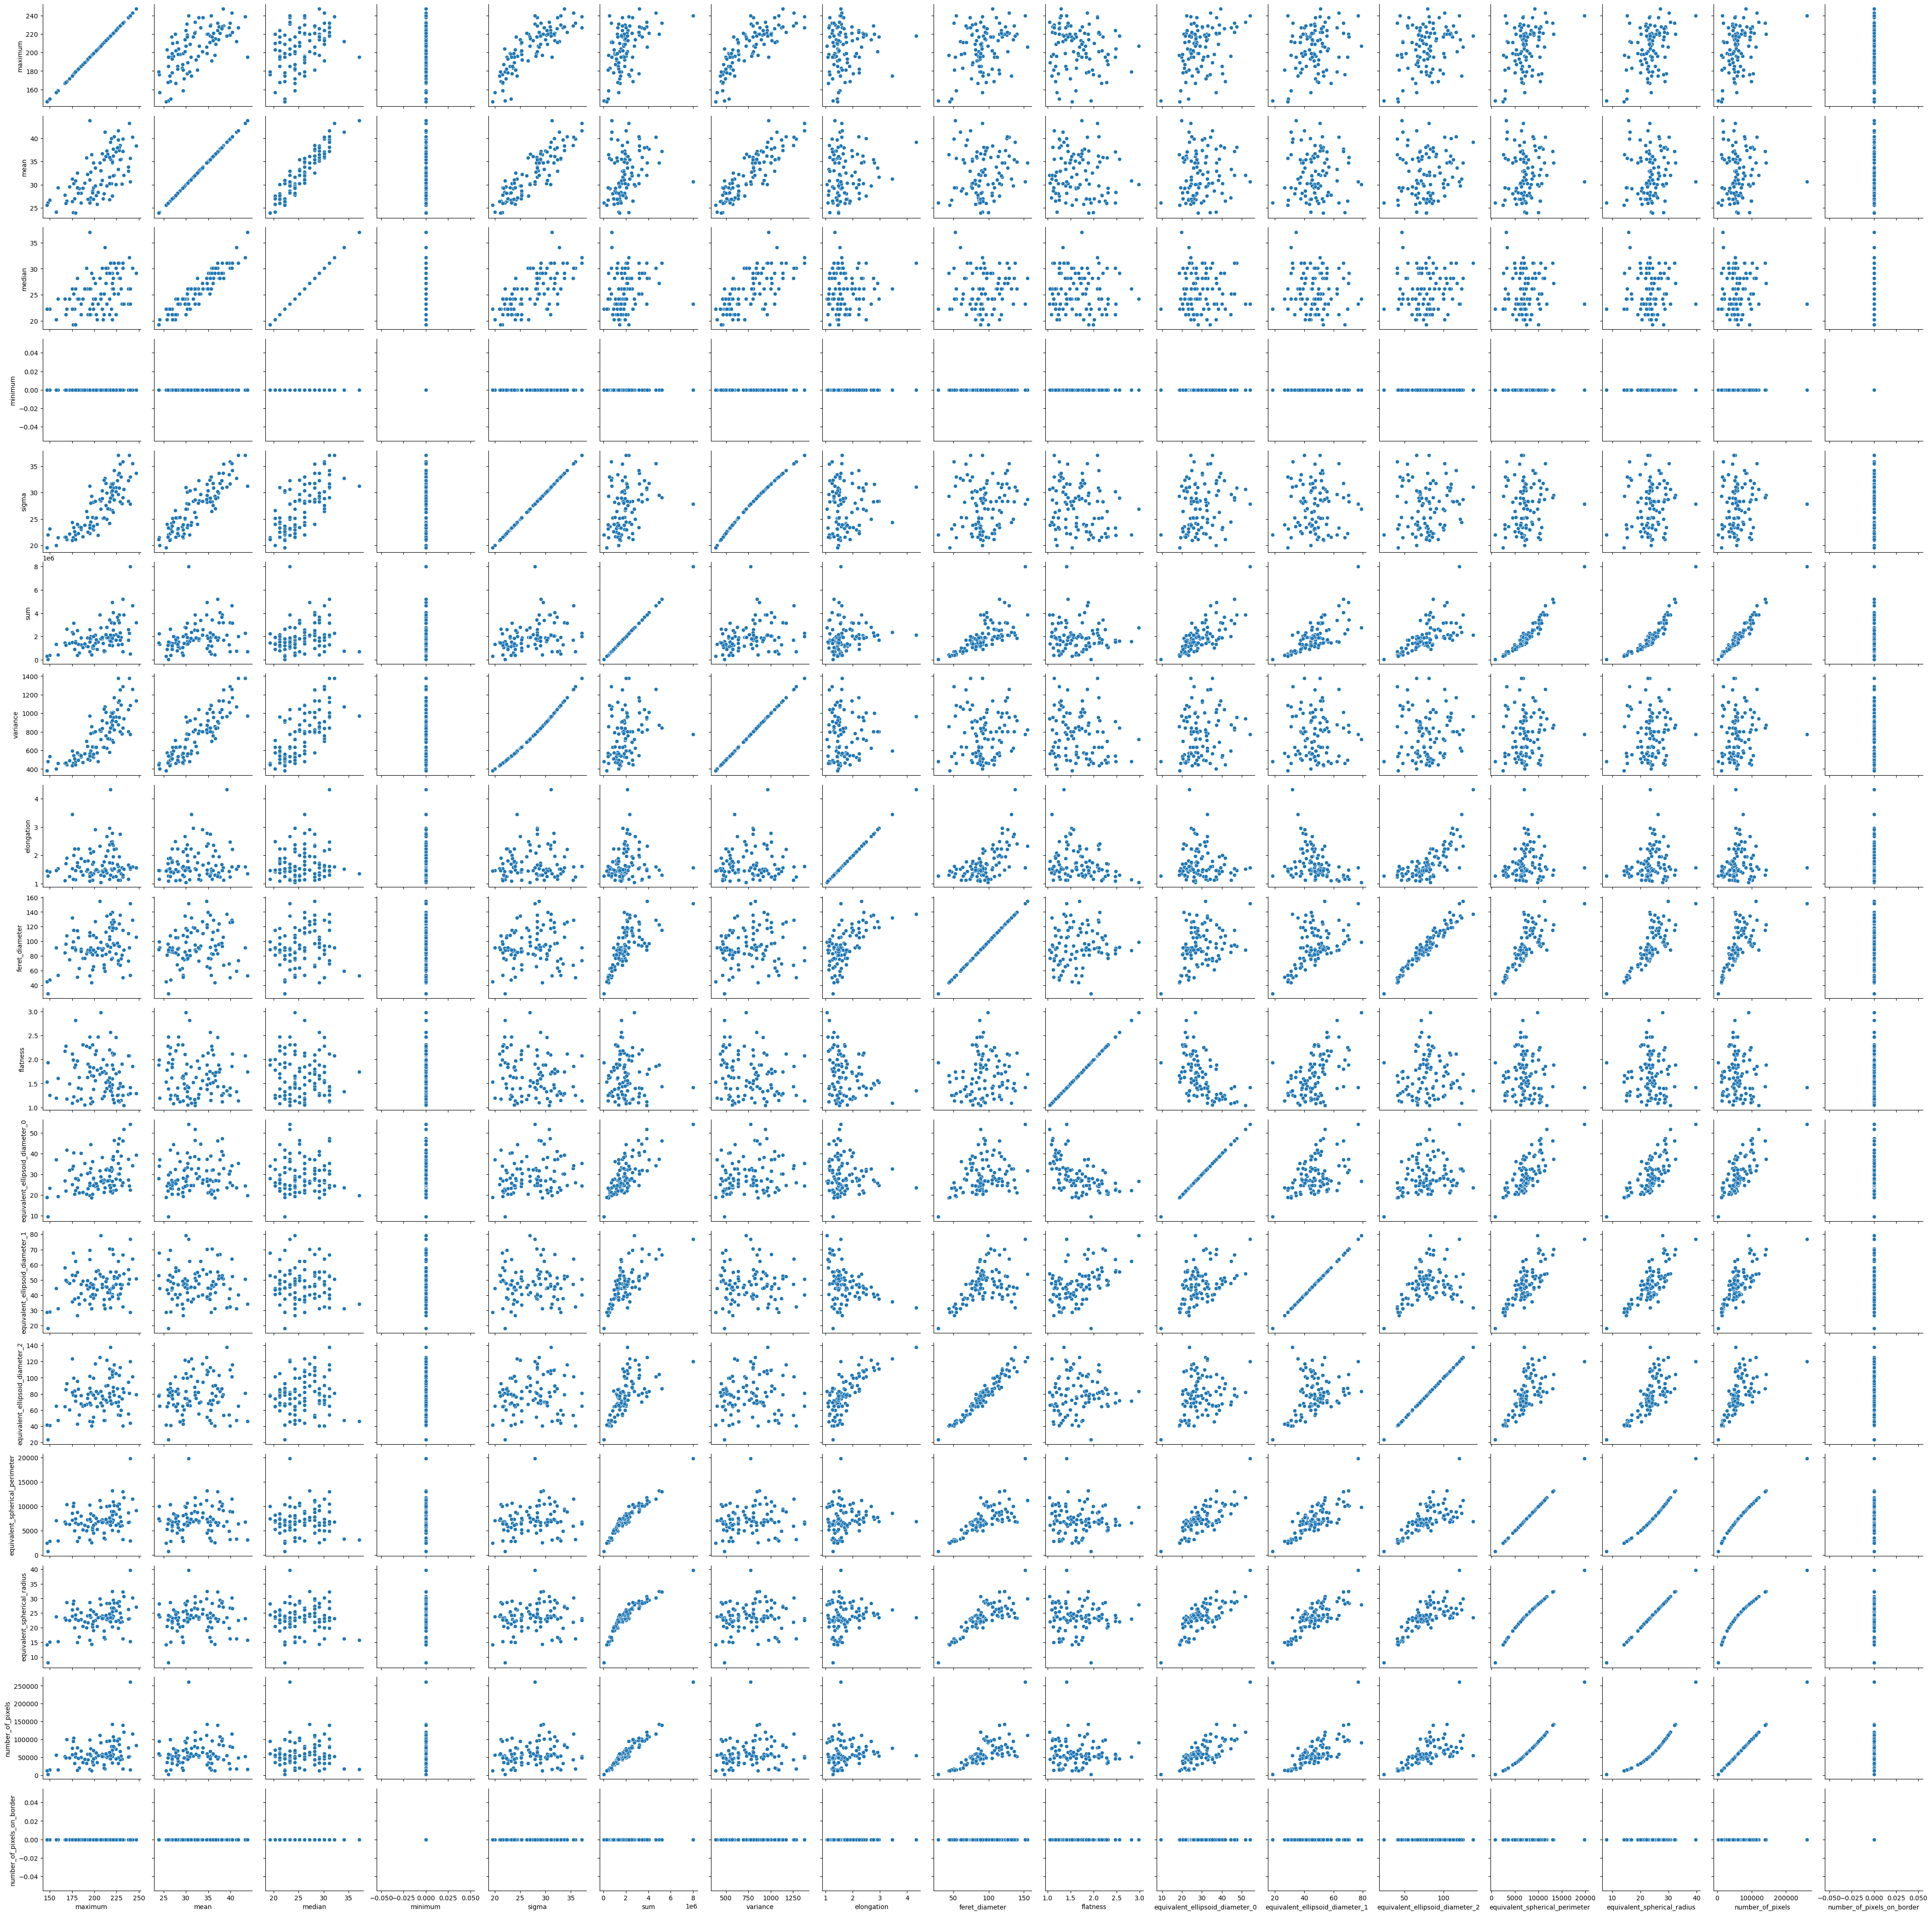

In [27]:
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

g = seaborn.PairGrid(selected_table)
g.map(seaborn.scatterplot)

In [28]:
reducer = umap.UMAP()
embedding2 = reducer.fit_transform(scaled_statistics)

seaborn.scatterplot(x=embedding2[:, 0], 
                    y=embedding2[:, 1])

NameError: name 'umap' is not defined

In [ ]:
stackview.curtain(image1_s,image2_esl,continuous_update=True, zoom_factor=2)

In [ ]:
stackview.side_by_side(image1_s,image2_esl,continuous_update=True, zoom_factor=2)